In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import trapezoid
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
import math
from sklearn.tree import DecisionTreeRegressor

In [2]:
dataframe_gpc = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/GPC Data/GPC_final.csv")

print(dataframe_gpc.shape[1])

index_labels = dataframe_gpc.index
gpc_RI = dataframe_gpc.filter(regex='RI_')
gpc_time = dataframe_gpc.filter(regex='Time\[min]_')

print(gpc_RI)
print(gpc_time)




10400
    RI_1          RI_2          RI_3          RI_4          RI_5  \
0    0.0 -5.178223e-09 -1.461212e-08 -2.305988e-08 -2.871510e-08   
1    0.0  0.000000e+00 -1.000000e-08 -2.000000e-08 -3.000000e-08   
2    0.0 -3.446817e-09 -1.015200e-08 -1.664642e-08 -2.071490e-08   
3    0.0 -3.945375e-09 -1.214538e-08 -1.926070e-08 -2.290487e-08   
4    0.0 -4.657183e-09 -1.297531e-08 -1.967043e-08 -2.346974e-08   
5    0.0 -2.168681e-09 -8.764830e-09 -1.908721e-08 -2.630661e-08   
6    0.0 -2.561619e-09 -9.683985e-09 -1.963544e-08 -2.719111e-08   
7    0.0 -1.594215e-08 -3.180124e-08 -3.642042e-08 -3.525522e-08   
8    0.0 -2.144436e-09 -8.318415e-09 -1.456955e-08 -1.740907e-08   
9    0.0 -3.148657e-09 -1.019514e-08 -1.661126e-08 -2.018344e-08   
10   0.0 -3.203900e-09 -1.064283e-08 -1.870268e-08 -2.389452e-08   
11   0.0 -2.140645e-09 -9.147313e-09 -1.855180e-08 -2.528449e-08   

            RI_6          RI_7          RI_8          RI_9         RI_10  ...  \
0  -3.210467e-08 -3.474840e-

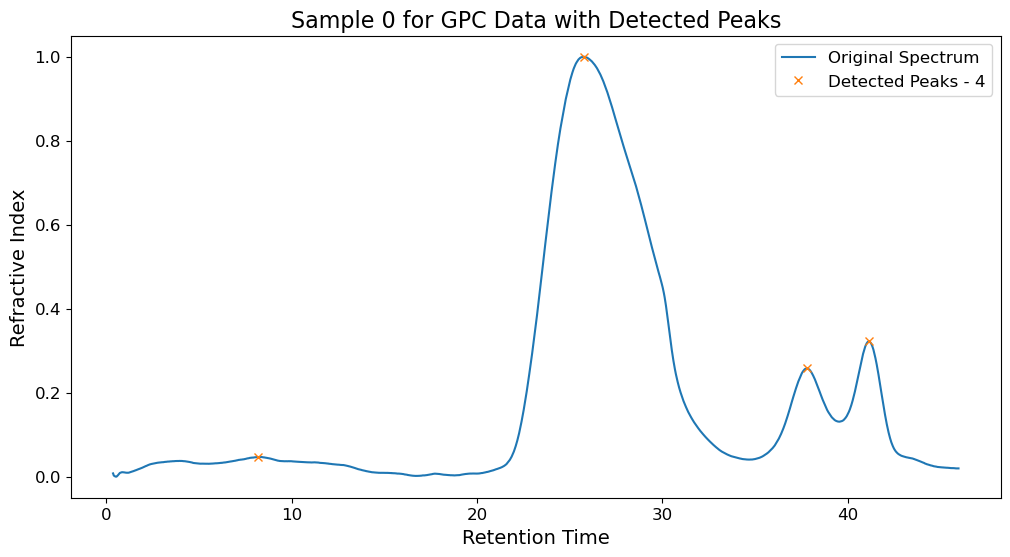

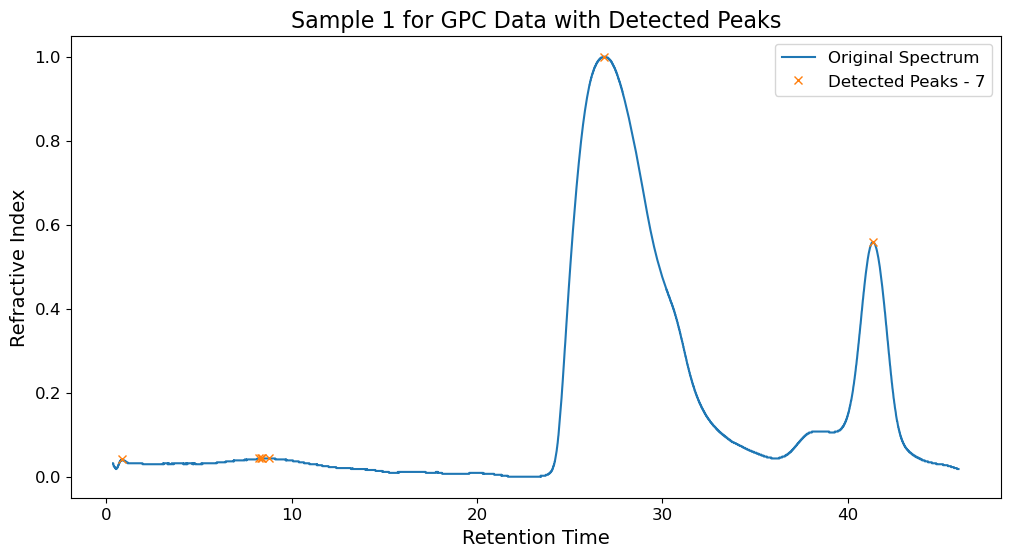

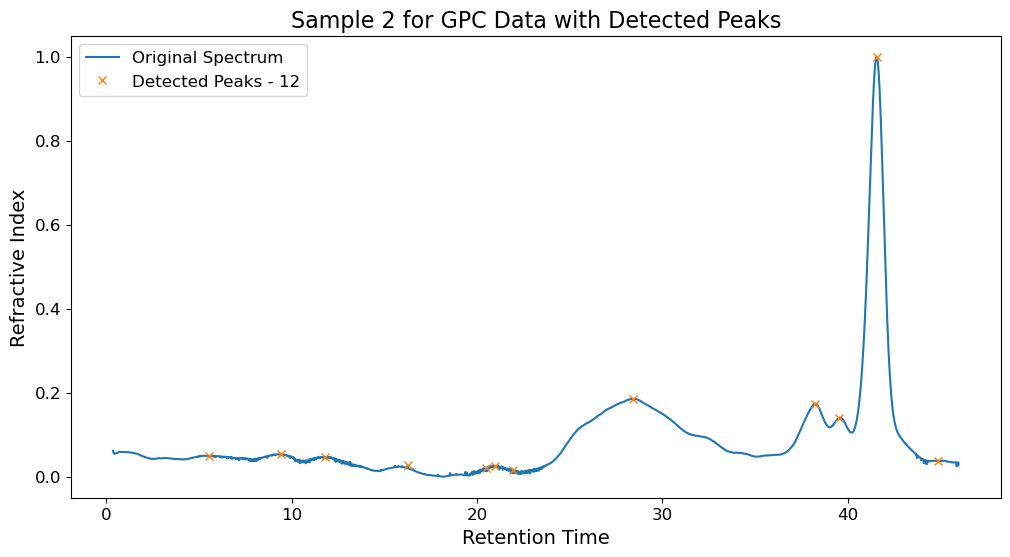

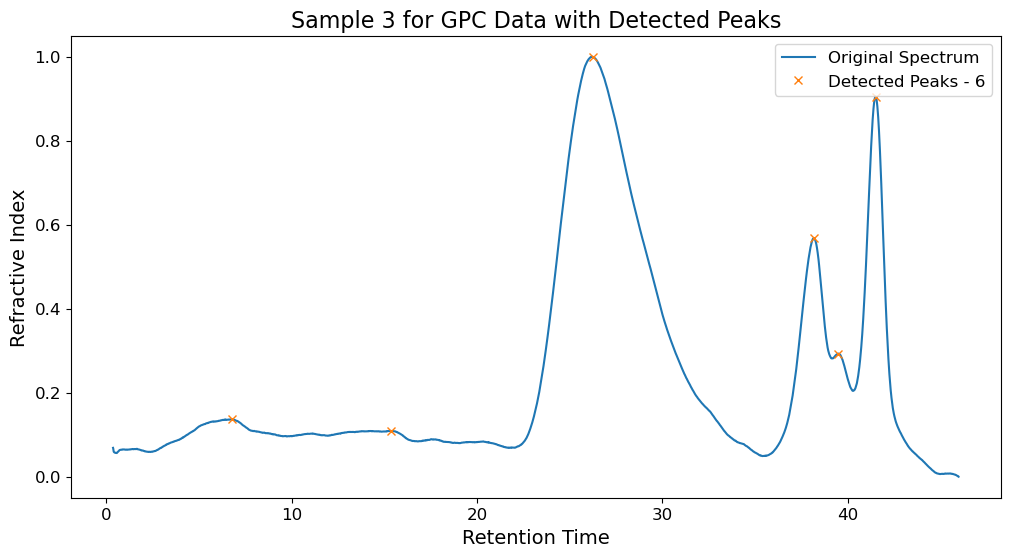

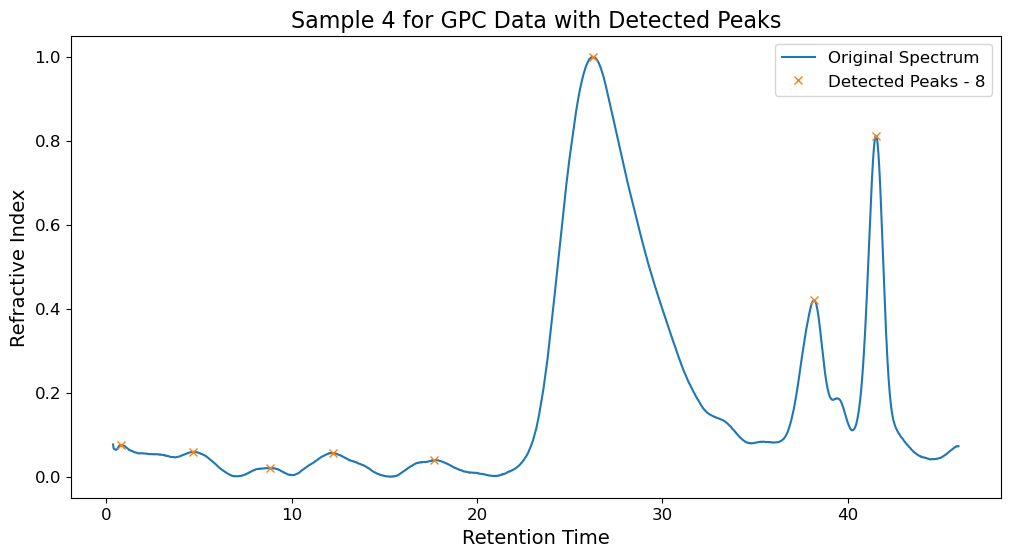

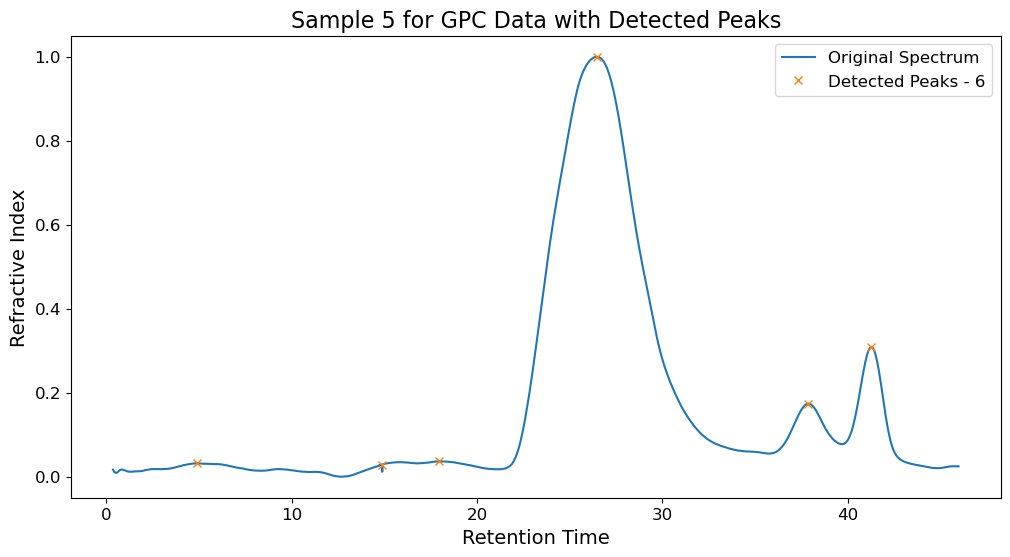

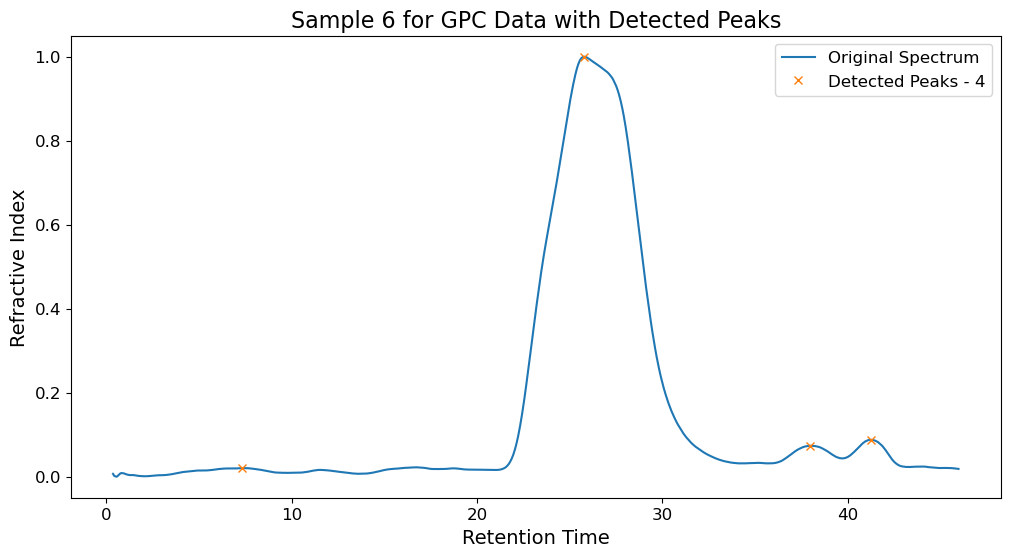

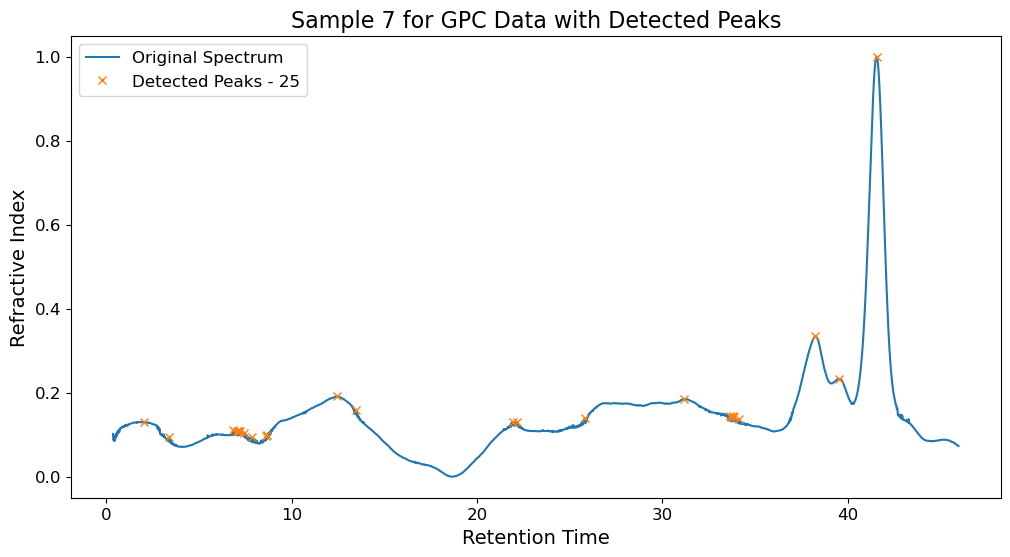

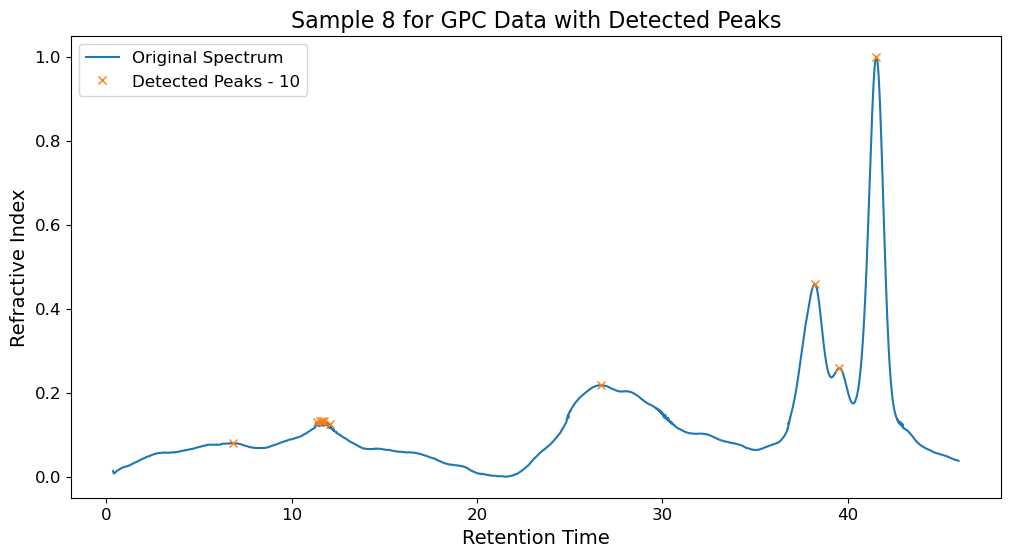

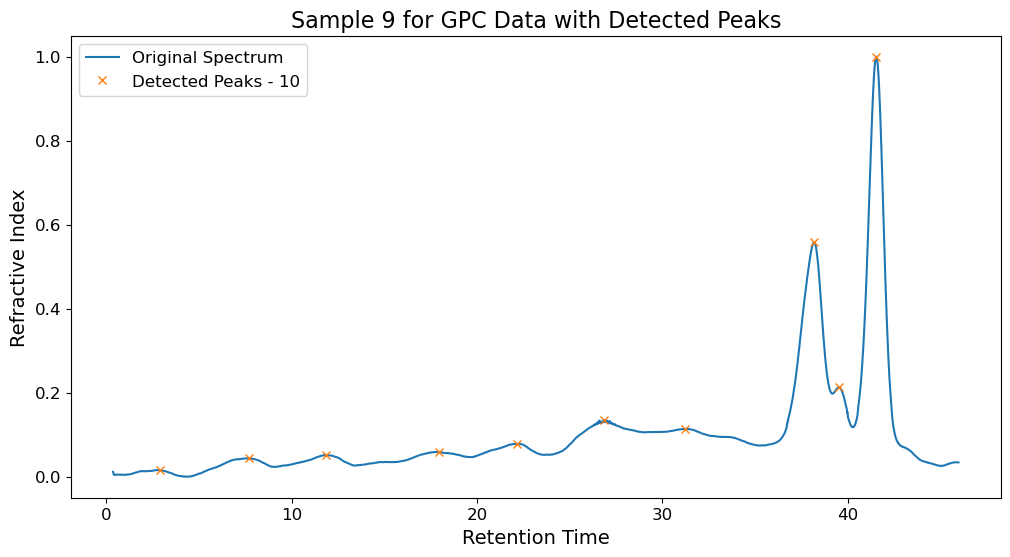

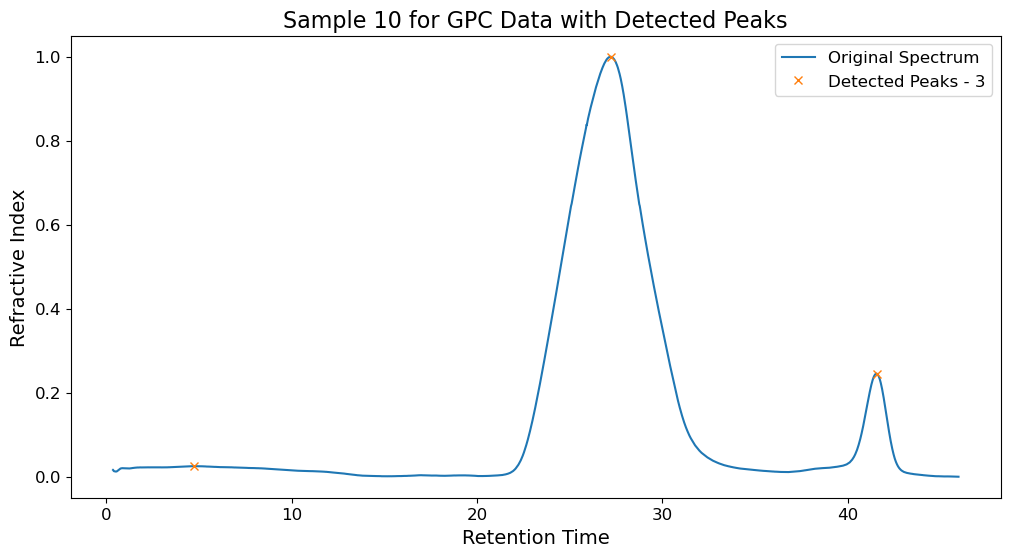

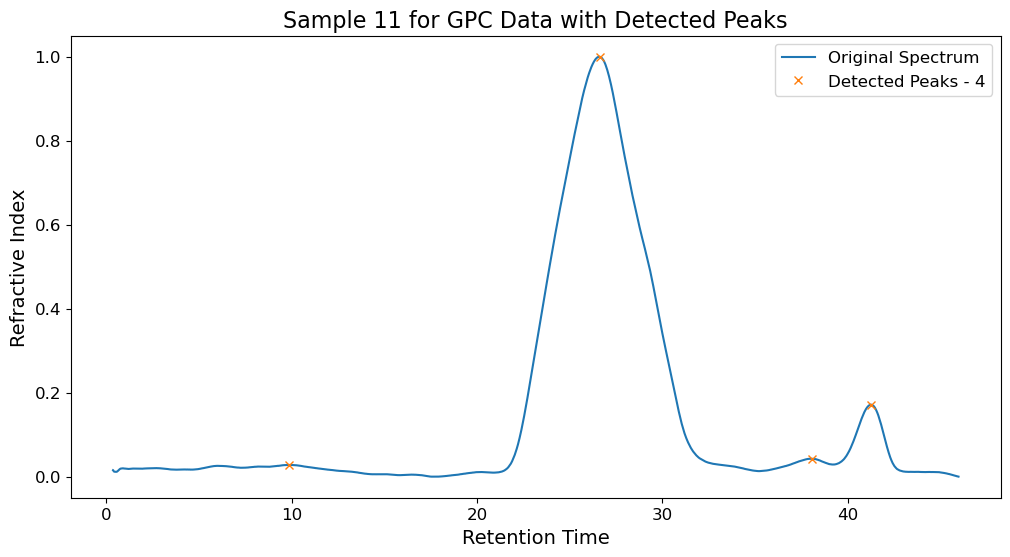

In [3]:
def load_and_normalize_data(filepath):
    gpc_df = pd.read_csv(filepath)
    index_labels = gpc_df.index
    gpc_RI = gpc_df.filter(regex='RI_' )
    gpc_time = gpc_df.filter(regex='Time\[min\]_')

    # Subtract min and divide by max-min for each row to normalize
    gpc_RI_Normalized = (gpc_RI.subtract(gpc_RI.min(axis=1), axis=0)
                                .div(gpc_RI.max(axis=1) - gpc_RI.min(axis=1), axis=0))
    return gpc_time, gpc_RI_Normalized, index_labels

filepath = "/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/GPC Data/GPC_final.csv"
gpc_time, gpc_RI, index_labels = load_and_normalize_data(filepath)




peaks_info = []

for sample_index in range(gpc_RI.shape[0]):
    spectrum = gpc_RI.iloc[sample_index, :].copy()
    
    org_spectrum = spectrum.copy()
    peaks, _ = find_peaks(spectrum, prominence=0.008)
    peak_count = len(peaks)
    peaks_info.append(peaks)


    plt.figure(figsize=(12, 6))
    plt.plot(gpc_time.iloc[sample_index, :], org_spectrum, label='Original Spectrum')
    plt.plot(gpc_time.iloc[sample_index, peaks], spectrum.iloc[peaks], "x", label=f'Detected Peaks - {peak_count}')
    #plt.xlim(10, 20)
    plt.title(f'Sample {sample_index} for GPC Data with Detected Peaks', fontsize=16)
    plt.xlabel('Retention Time', fontsize=14)
    plt.ylabel('Refractive Index', fontsize=14)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.legend(fontsize=12)
    plt.show()


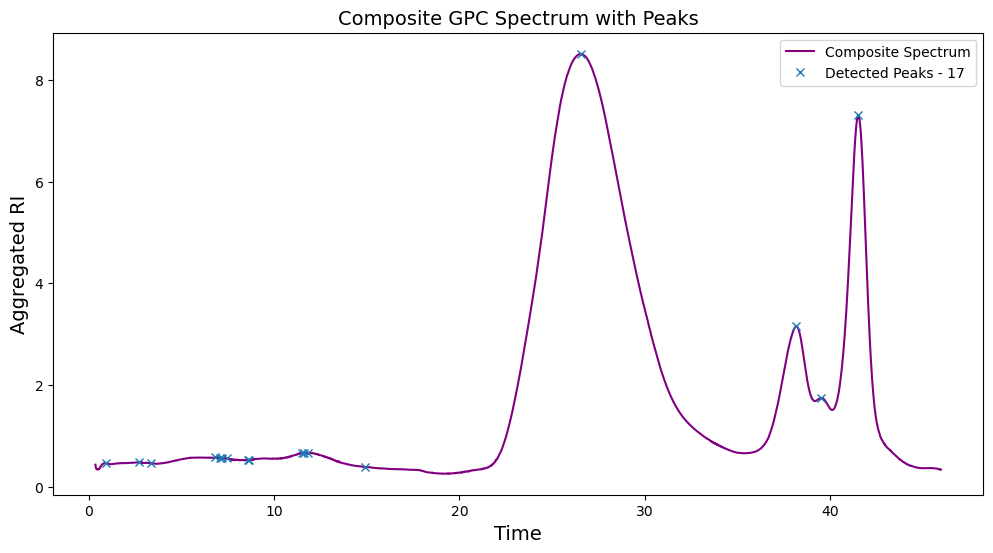

       Bin_0     Bin_1     Bin_2     Bin_3     Bin_4     Bin_5     Bin_6  \
0   0.007075  0.119808  0.002535  0.273855  0.004144  0.019071  0.006613   
1   0.027952  0.141687  0.002168  0.265739  0.004095  0.018427  0.006293   
2   0.050044  0.217992  0.003080  0.333841  0.004523  0.020384  0.006738   
3   0.054213  0.345912  0.005540  0.803408  0.013899  0.060547  0.018961   
4   0.059772  0.257493  0.003413  0.190032  0.000111  0.000995  0.000729   
5   0.011631  0.088550  0.001344  0.161861  0.002247  0.009684  0.002946   
6   0.004454  0.027758  0.000351  0.102350  0.002101  0.009592  0.003227   
7   0.100025  0.467425  0.006157  0.722870  0.010983  0.049407  0.015667   
8   0.018268  0.218235  0.004010  0.536745  0.008330  0.036750  0.011739   
9   0.004333  0.036086  0.000724  0.173358  0.004384  0.019950  0.006846   
10  0.015794  0.100304  0.001579  0.154362  0.002293  0.010247  0.003371   
11  0.015169  0.083257  0.001256  0.164676  0.002300  0.010246  0.003392   

       Bin_

In [4]:
def aggregate_intensities(gpc_RI):

    return gpc_RI.sum(axis=0)

def bin_around_peaks(gpc_RI, gpc_time, widths):

    binned_data_list = []

    for i in range(gpc_RI.shape[0]):
        sample_RI = gpc_RI.iloc[i, :].values
        time_values = gpc_time.iloc[i, :].values
        binned_sample_data = []

        for j, peak in enumerate(no_water_peaks):

            window_width = int(widths[0][j])
            window_start = max(0, peak - window_width)
            window_end = min(len(sample_RI), peak + window_width + 1)
            bin_area = np.trapz(sample_RI[window_start:window_end], time_values[window_start:window_end])
            binned_sample_data.append(bin_area)

        binned_data_list.append(binned_sample_data)

    return pd.DataFrame(binned_data_list, columns=[f'Bin_{i}' for i in range(len(no_water_peaks))])


composite_spectrum = aggregate_intensities(gpc_RI)


no_water_peaks, properties = find_peaks(composite_spectrum, prominence=0.01)  # adjust prominence as needed
widths = peak_widths(composite_spectrum, no_water_peaks, rel_height=0.995)

# Perform binning based on the peak widths
binned_data_df = bin_around_peaks(gpc_RI, gpc_time, widths)

plt.figure(figsize=(12, 6))
plt.plot(gpc_time.iloc[1, :], composite_spectrum, color='Purple', label='Composite Spectrum')
plt.plot(gpc_time.iloc[1, no_water_peaks], composite_spectrum[no_water_peaks], "x", label=f'Detected Peaks - {len(no_water_peaks)}')
plt.legend()
plt.title('Composite GPC Spectrum with Peaks', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Aggregated RI', fontsize=14)
plt.show()


print(binned_data_df)
print("Left IPS:", widths[2])
print("Right IPS:", widths[3])

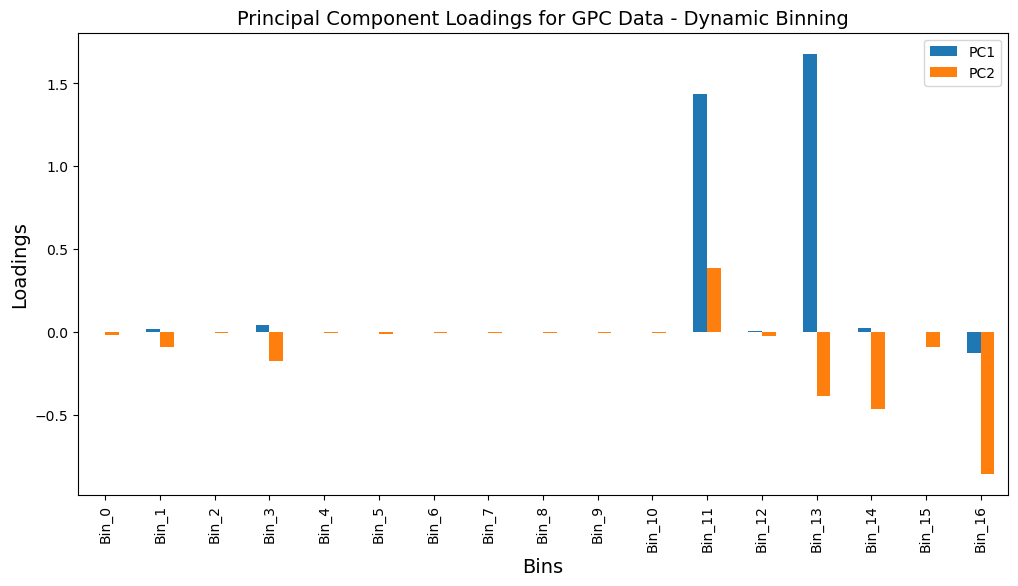

[0.78354043 0.2048586 ]


In [5]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(binned_data_df)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=binned_data_df.columns)

fig, ax = plt.subplots(figsize=(12,6))
loading_matrix.plot(kind='bar', ax=ax)
plt.title('Principal Component Loadings for GPC Data - Dynamic Binning', fontsize=14)
plt.ylabel('Loadings', fontsize=14)
plt.xlabel('Bins', fontsize=14)
plt.show()

# print(principal_df)
# print(loading_matrix)
print(pca.explained_variance_ratio_)

Scree Plot for the Prinicpal Components

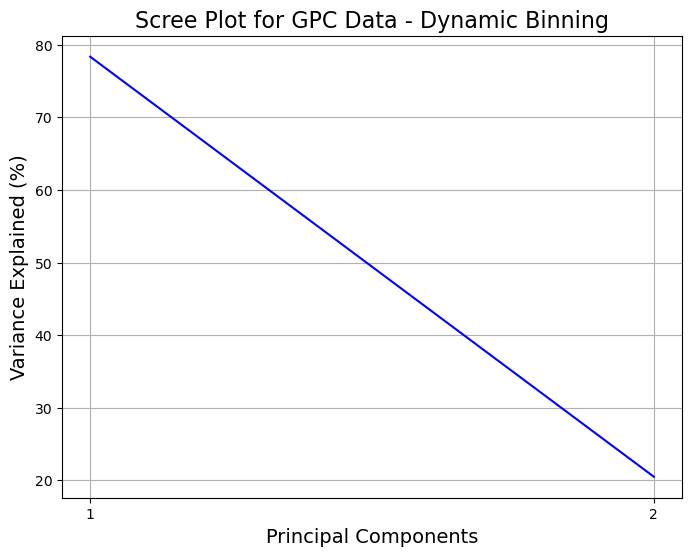

In [6]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance*100, color='blue')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Scree Plot for GPC Data - Dynamic Binning', fontsize=16)
plt.xticks(range(1, len(explained_variance)+1))  # Ensure ticks correspond to components
plt.grid(True)
plt.show()

In [7]:
principal_df.to_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/GPC Data/PC_GPC.csv")

In [8]:
performance_data = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/tidy_performance_2.0.csv", index_col='Sample')
Y = performance_data['Performance (mean)']

Y.reset_index(drop=True, inplace=True)


poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(principal_df)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, Y)
Y_pred_poly = lin_reg_poly.predict(X_poly)


Mean_abs_error = mean_absolute_error(Y, Y_pred_poly)
Mean_sqr_error = mean_squared_error(Y, Y_pred_poly)

print("Mean Absolute Error for GPC Data:", Mean_abs_error)
print("Mean Sqaure Error for GPC Data:", Mean_sqr_error)


r_sqaure_poly = r2_score(Y, Y_pred_poly)

X_poly_sm = sm.add_constant(X_poly)
ols_model_poly = sm.OLS(Y, X_poly_sm).fit()
ols_summary_poly = ols_model_poly.summary()

print("R-Sqaured for Linear Regression:", r_sqaure_poly)
print("OLS Summary:", ols_summary_poly)

Mean Absolute Error for GPC Data: 2.020646627942319
Mean Sqaure Error for GPC Data: 6.050983912139338
R-Sqaured for Linear Regression: 0.3732076283679111
OLS Summary:                             OLS Regression Results                            
Dep. Variable:     Performance (mean)   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     2.679
Date:                Sat, 03 Aug 2024   Prob (F-statistic):              0.122
Time:                        21:35:26   Log-Likelihood:                -27.829
No. Observations:                  12   AIC:                             61.66
Df Residuals:                       9   BIC:                             63.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


In [9]:
print(Y_pred_poly)

[15.79969988 16.24632394 16.36584162 18.45506955 17.39489305 14.89062331
 13.37695404 18.16677751 18.17873844 17.97566184 13.37472198 13.37469485]


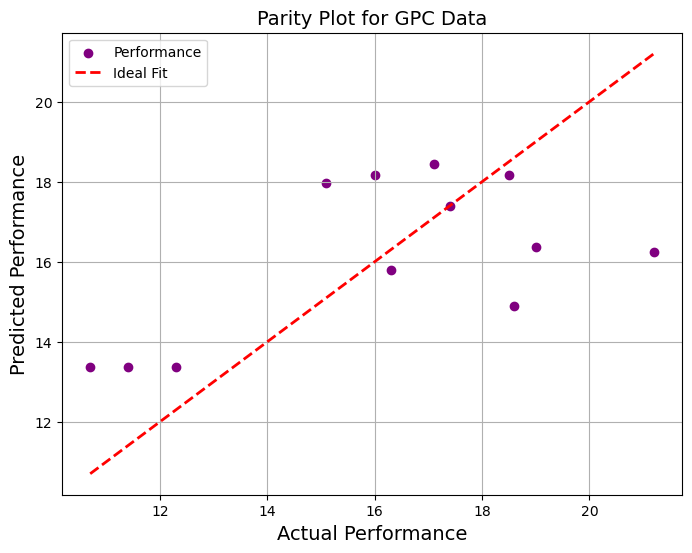

In [10]:

plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred_poly, color= 'Purple', label='Performance')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Performance', fontsize=14)
plt.ylabel('Predicted Performance', fontsize=14)
plt.title('Parity Plot for GPC Data', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()